## Autorzy

1. Konrad Filek 
2. Wojciech Kozioł

## Opis problemu

Nasza praca będzie realizować próbę sprawdzenia, 
czy dana płatność jest próbą oszustwa, czy tez nie, na podstawie bazy danych CSV
pobranej ze strony kaggle.com

Link do zbioru danych: https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud

Zbiór danych wybrany przez nas, został stworzony na bazie transakcji wykonanych kartami kredytowymi we wrześniu 2013 w europie na przestrzeni dwóch dni, gdzie z pośród 284 807 transakcji, zakwalifikowano 492 oszustwa.

## Czym jest "analiza składowych głowny (PCA)"

Źródło: https://www.statystyka.az.pl/analiza-skladowych-glownych-pca.php

"Analiza składowych głównych (PCA) służy m.in. do redukcji liczby zmiennych opisujących zjawiska, czy do odkrycia prawidłowości między zmiennymi. Polega ona na wyznaczeniu składowych będących kombinacją liniową badanych zmiennych. Dokładna analiza składowych głównych umożliwia wskazanie tych zmiennych początkowych, które mają duży wpływ na wygląd poszczególnych składowych głównych czyli tych, które tworzą grupę jednorodną. Składowa główna (u której wariancja jest zmaksymalizowana) jest wówczas reprezentantem tej grupy."

Kolejne składowe:

- są wzajemnie nieskorelowane,
- są definiowane tak, aby zmaksymalizować zmienność, która nie została wyjaśniona przez poprzednią składową,

Liczba składowych jest mniejsza lub równa liczbie zmiennych początkowych. 
Wariancja składowej głównej `Zi` jest równa `i-tej` co do wielkości wartości własnej macierzy `𝔸`.
Całkowita wariancja układu jest równa `λ1+λ2+…+λp`(gdzie `λi` dla `i∈{1,2,…,p}`są wszystkimi wartościami własnymi macierzy `𝔸`). 
Dzięki temu możemy zdefiniować część wariancji dla `i-tej` składowej według wzoru:

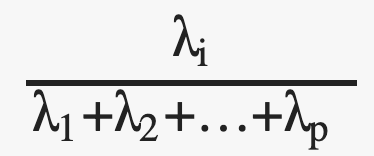

## Opis danych ze zbioru danych

- `time` czas dokonania transakcji
- `V1 - V28` cechy transakcji uzyskane na podstawie transformacji PCA
- `amount` kwota transakcji
- `class` definiuje transakcje czy jest oszustwem (wartość `1`), czy tez nie (wartość `0`)

## Realizacja programu
### Import bibliotek

In [42]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.preprocessing import PowerTransformer
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

### Ladowanie danych

In [37]:
df=pd.read_csv('./creditcard.csv')
df.shape

(284807, 31)

za pomocą `df.head()` sprawdzamy pięc pierwszych wierszy danych które załadowaliśmy

In [38]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [16]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [17]:
print("Dane: ilość wierszy:",df.shape[0]," ilość kolumn:", df.shape[1])

Dane: ilość wierszy: 284807  ilość kolumn: 31


## Sprawdzenie kompletności danych

In [18]:
total = df.isnull().sum().sort_values(ascending = False)
percent = (df.isnull().sum()/df.isnull().count()*100).sort_values(ascending = False)
pd.concat([total, percent], axis=1, keys=['Total', 'Percent']).transpose()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
Total,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Percent,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


wynik wskazuje na to, ze nasz zbior danych jest kompletny

## Zbalansowanie danych

<Axes: xlabel='Class'>

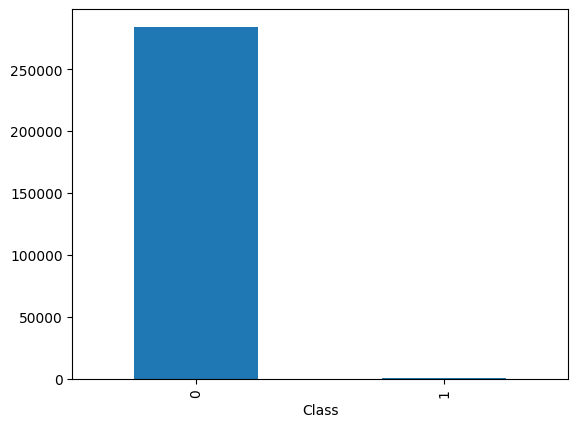

In [19]:
df['Class'].value_counts().plot(kind='bar')

Powyzszy wykres wskazuje na to ze nasze dane sa skrajnie nie zbalansowane. Brak zbalansowania danych prowadzi do:
1. Skrzywienia modelu
2. Niskiej zdolności do generalizacji
3. Sprawienia, ze dokładnośc moze byc razaco wysoka poniewaz model bedzie przewidywac zawsze dominujaca klase

Aby rozwiazac problem niezbalansowania danych mozemy skorzystac z techniki oversamplingu, czyli zwiekszenia liczby probek z mniejszych klas. Ale zanim dojdziemy do tego zredukujemy ilość duplikatów, a następnie skorzystamy z metody Smote

Metoda SMOTE (Synthetic Minority Over-sampling Technique) to metoda przeznaczona do radzenia sobie z problemem niezbalansowanych danych w zadaniach klasyfikacji. Głównym celem SMOTE jest zwiększenie liczby przykładów w mniejszych klasach poprzez generowanie sztucznych (syntetycznych) przykładów dla tych klas, aby zrównoważyć rozkład klas.

Przejdźmy do działania

In [20]:
df.duplicated().sum()

1081

Mamy 1081 wierszy które są duplikatami, usuńmy je

In [21]:
df.drop_duplicates(keep=False,inplace=True)

metoda `drop_duplicates` pozbywa się jak sama nazwa wskazuje duplikatów, została uruchomiona z dwoma opcjami:
1. `keep=False` argument ten sprawia e metoda usunie wszystkie wiersze które są duplikatami (wszystkie wiersze które mają takie same wartości we wszystkich kolumnachniezależnie od tego, który z wierszy zostanie zachowany. W praktyce oznacza to, że wszystkie duplikaty zostaną usunięte.)
2. `inplace=True` Ten argument jest opcjonalny i domyślnie ustawiony na False. Jeśli inplace jest ustawione na True, to metoda drop_duplicates zmieni ramkę danych df bez konieczności przypisywania wyniku do nowej zmiennej. W efekcie ramka danych df zostanie zaktualizowana i będzie zawierała tylko unikalne wiersze.

In [22]:
df.duplicated().sum()

0

In [23]:
print("Dane: ilość wierszy:",df.shape[0]," ilość kolumn:", df.shape[1])

Dane: ilość wierszy: 282953  ilość kolumn: 31


Jak widzimy udało sie nam pozbyć 1854 rekordy. Wpłynęło to raczej marginalnie na zbalansowanei zbioru. Skorzystajmy teraz z metody SMOTE

(564986, 30) (564986,)
Axes(0.125,0.11;0.775x0.77)


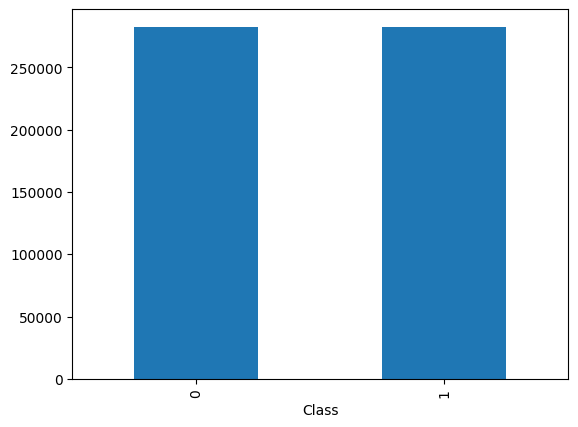

In [24]:
x=df.iloc[:,:-1]
y=df.iloc[:,-1]

smote=SMOTE()
x,y=smote.fit_resample(x,y)

print(x.shape,y.shape)
print(y.value_counts().plot(kind='bar'))

wygląda na to ze udało nam się zbalansować nasz model

## Generowanie mapy cieplnej 

Teraz wygenerujmy mapę cieplną korelacji róznych cech w ramach naszego zbioru danych. Ten rodzaj wizualizacji jest przydatny w fazie eksploracyjnej analizy danych (EDA). Pozwala nam zrozumieć jak mocno są powiązane ze sobą poszczególne zmienne (cechy).

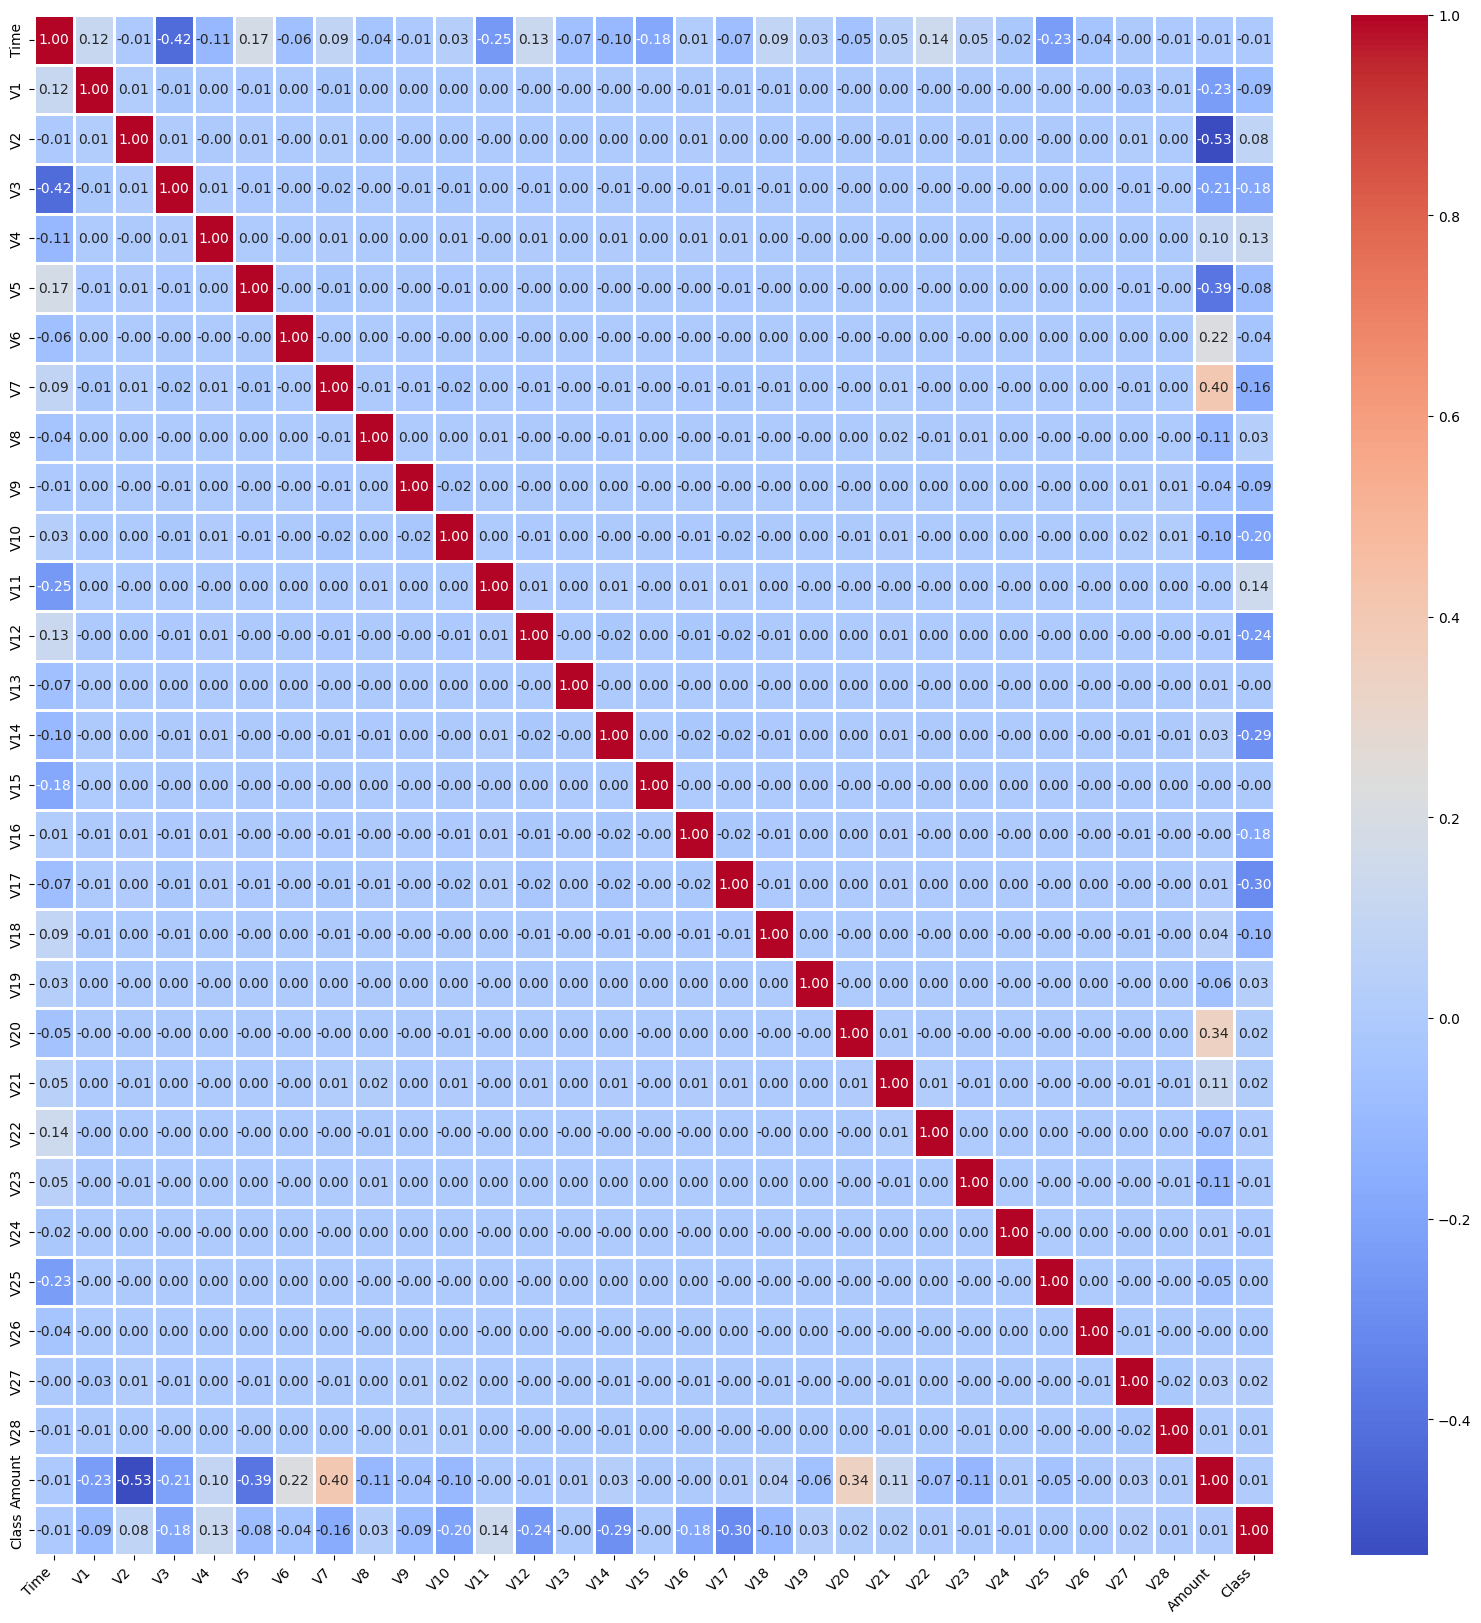

In [25]:
plt.figure(figsize=(20, 20))

# Create the heatmap with labels and annotations
dataplot = sns.heatmap(
    df.corr(),
    annot=True,  # Display the correlation values in each cell
    cmap='coolwarm',  # Choose a suitable colormap
    fmt='.2f',  # Format the correlation values with 2 decimal places
    linewidths=1,  # Adjust cell border width
)
# Rotate x-axis labels for better readability
dataplot.set_xticklabels(dataplot.get_xticklabels(), rotation=45, ha='right')

plt.show()

Powyzszy wykres dostarcza nam kilka istotnych informacji
1. Czerwone komórki wskazują na wysoką korelację między zmiennymi. Jeśli są to cechy różne od samej siebie, wtedy możemy przypuszczać, że jedna cecha może być przewidywalna na podstawie drugiej. W naszym przypadku mamy do czynienia z korelacją doskonałą poniewaz po diagonali mamy same jedynki (zmienna porównywana jest z samą sobą)
2. Niebieskie komórki wskazują na niską lub żadną korelację. Zmienne z takimi wartościami prawdopodobnie nie dostarczają podobnych informacji i mogą być traktowane jako niezależne w analizie.

Na podstawie tych dwóch informacji mozemy stwierdzic ze nasz zbiór nie wykazuje silnych korelacji miedzy zmiennymi niezaleznymi (multikolinearnosc), dzieki czemu nasz model powinien byc całkiem stabilny. Wobec czego nie musimy na tym etapie dokonywać kolejnych transformacji zbioru.

## Model

In [27]:
target = 'Class'
predictors = ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',\
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19',\
       'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28',\
       'Amount']

In [28]:
RFC_METRIC = 'gini'  #metric used for RandomForrestClassifier
NUM_ESTIMATORS = 100 #number of estimators used for RandomForrestClassifier
NO_JOBS = 4 #number of parallel jobs used for RandomForrestClassifier

#TRAIN/VALIDATION/TEST SPLIT
#VALIDATION
VALID_SIZE = 0.20 # simple validation using train_test_split
TEST_SIZE = 0.20 # test size using_train_test_split

#CROSS-VALIDATION
NUMBER_KFOLDS = 5 #number of KFolds for cross-validation

RANDOM_STATE = 2018
MAX_ROUNDS = 1000 #lgb iterations
EARLY_STOP = 50 #lgb early stop 
OPT_ROUNDS = 1000  #To be adjusted based on best validation rounds
VERBOSE_EVAL = 50 #Print out metric result


In [29]:
train_df, test_df = train_test_split(df, test_size=TEST_SIZE, random_state=RANDOM_STATE, shuffle=True )
train_df, valid_df = train_test_split(train_df, test_size=VALID_SIZE, random_state=RANDOM_STATE, shuffle=True )

In [31]:
rf=RandomForestClassifier(n_jobs=NO_JOBS, 
                             random_state=RANDOM_STATE,
                             criterion=RFC_METRIC,
                             n_estimators=NUM_ESTIMATORS,
                             verbose=False)

rf.fit(train_df[predictors], train_df[target].values)

RandomForestClassifier(n_jobs=4, random_state=2018, verbose=False)

In [33]:
preds = rf.predict(valid_df[predictors])

/var/folders/5v/q3m3y_q17hl7wk_2wmcvtj6r0000gn/T/ipykernel_94242/103793780.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  s.set_xticklabels(s.get_xticklabels(),rotation=90)


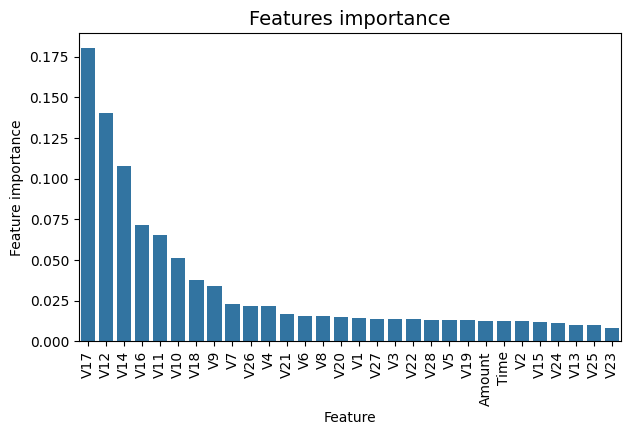

In [34]:
tmp = pd.DataFrame({'Feature': predictors, 'Feature importance': rf.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (7,4))
plt.title('Features importance',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()   

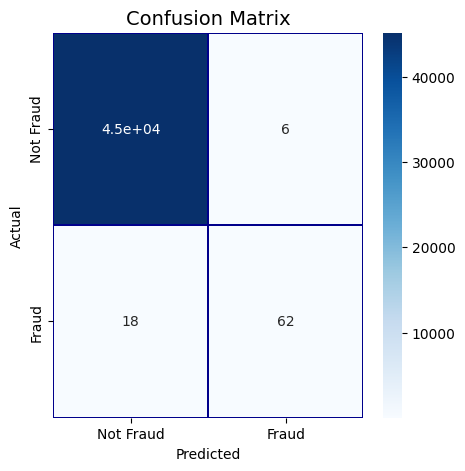

In [35]:
cm = pd.crosstab(valid_df[target].values, preds, rownames=['Actual'], colnames=['Predicted'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cm, 
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkblue", cmap="Blues")
plt.title('Confusion Matrix', fontsize=14)
plt.show()

## Modele

Spróbujemy zaimplementować dwa modele:
1. RandomForestClassifier
2. XGBoost


### RandomForestClassifier czym jest?
Wyobraź sobie, że masz do rozwiązania skomplikowany problem, a następnie zbierasz grupę ekspertów z różnych dziedzin, aby dostarczyli swoich opinii. Każdy ekspert wyraża swoje zdanie oparte na swojej wiedzy i doświadczeniach. Następnie eksperci głosują, aby dojść do ostatecznej decyzji.

W klasyfikacji za pomocą losowego lasu tworzone są wiele drzew decyzyjnych przy użyciu różnych losowych podzbiorów danych i cech. Każde drzewo decyzyjne jest jak ekspert, który wyraża swoją opinię na temat klasyfikacji danych. Predykcje są dokonywane poprzez obliczenie predykcji dla każdego drzewa decyzyjnego, a następnie wybranie najpopularniejszego wyniku (w przypadku regresji, używa się techniki uśredniania zamiast głosowania).

Na poniższym diagramie mamy losowy las składający się z n drzew decyzyjnych, a pokazaliśmy pierwsze 5 z nich wraz z ich predykcjami (albo "Pies" albo "Kot"). Każde drzewo jest narażone na różną liczbę cech i różny próbkowy zestaw oryginalnego zbioru danych, dlatego każde drzewo może być inne. Każde drzewo dokonuje predykcji. Patrząc na pierwsze 5 drzew, widzimy, że 4 z 5 przewidziały, że próbka to Kot. Zielone okręgi oznaczają hipotetyczną ścieżkę, którą drzewo podążyło, aby osiągnąć swoją decyzję. Losowy las zlicza liczbę predykcji drzew decyzyjnych dla Kotów i Psów, a następnie wybiera najpopularniejszą predykcję.

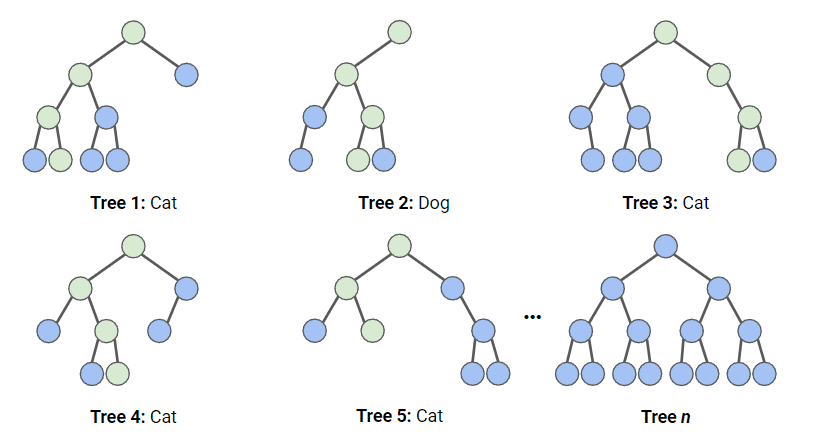

Źródło: https://www.datacamp.com/tutorial/random-forests-classifier-python

In [39]:
clf = RandomForestClassifier(n_jobs=NO_JOBS, 
                             random_state=RANDOM_STATE,
                             criterion=RFC_METRIC,
                             n_estimators=NUM_ESTIMATORS,
                             verbose=False)

clf.fit(train_df[predictors], train_df[target].values)

preds = clf.predict(valid_df[predictors])

## Przestrzeń pod krzywą

Funkcja `roc_auc_score` to metryka używana do oceny jakości modeli klasyfikacji binarnej w uczeniu maszynowym. ROC-AUC (Receiver Operating Characteristic - Area Under the Curve) mierzy zdolność modelu do rozróżniania między dwiema klasami (np. pozytywną i negatywną) na podstawie wyników przewidywań.


In [41]:
roc_auc_score(valid_df[target].values, preds)

0.8874336180381918

W teście ROC-AUC model `RandomForrestClassifier` osiągnął wynik `0.88`.

## XGBoost

XGBoost (eXtreme Gradient Boosting) to potężna i wysoce efektywna biblioteka do uczenia maszynowego, która jest często stosowana do problemów klasyfikacji i regresji. Jest to rodzaj algorytmu Gradient Boosting, który może być używany do tworzenia silnych modeli predykcyjnych. Działa on w następujący sposób:

1. Na początek, algorytm tworzy pewną ilość drzew decyzyjnych (jak drzewa genealogiczne, ale do przewidywań).

2. Każde drzewo stara się zrozumieć, co wpływa na to, co chcemy przewidzieć, na przykład jakie słowa w wiadomości wskazują na spam.

3. Ale żaden z tych drzew nie jest idealny, każdy popełnia błędy.

4. Teraz XGBoost bierze te błędy i próbuje zrozumieć, jakie błędy popełniły drzewa.

5. Następnie algorytm tworzy nowe drzewo, które próbuje poprawić te błędy i być lepszym od innych drzew.

6. Proces ten powtarza się wiele razy, tworząc wiele drzew i poprawiając je, aż otrzymasz silny model, który potrafi dobrze przewidywać.

7. W rezultacie, możesz go używać do podejmowania decyzji lub przewidywania wyników na podstawie nowych danych, na przykład przewidywać, czy email jest spamem czy też nie.

In [44]:
# To są obiekty xgb.DMatrix, które służą do przechowywania danych treningowych, 
# walidacyjnych i testowych w formacie odpowiednim dla biblioteki XGBoost. 
# Te obiekty zawierają cechy (predictors) i etykiety (target) z odpowiednich zbiorów danych.
dtrain = xgb.DMatrix(train_df[predictors], train_df[target].values)
dvalid = xgb.DMatrix(valid_df[predictors], valid_df[target].values)
dtest = xgb.DMatrix(test_df[predictors], test_df[target].values)

# To jest lista krotek, która zawiera pary (dane, etykieta), gdzie dane to obiekt xgb.DMatrix, 
# a etykieta to etykieta zestawu danych,  np. 'train' dla danych treningowych i 'valid' dla 
# danych walidacyjnych. Ta lista jest używana do monitorowania wyników modelu na danych treningowych i 
# walidacyjnych podczas treningu.
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

# To jest słownik (dictionary), który zawiera różne parametry konfiguracyjne dla modelu XGBoost, 
# takie jak rodzaj zadania ('objective'), współczynnik uczenia ('eta'), 
# maksymalna głębokość drzew ('max_depth'), itp. Parametry te wpływają na zachowanie i wydajność modelu.
params = {}
params['objective'] = 'binary:logistic'
params['eta'] = 0.039
params['silent'] = True
params['max_depth'] = 2
params['subsample'] = 0.8
params['colsample_bytree'] = 0.9
params['eval_metric'] = 'auc'
params['random_state'] = RANDOM_STATE

In [45]:
# To jest obiekt modelu XGBoost, który jest trenowany na danych treningowych (dtrain) 
# z wykorzystaniem określonych parametrów. Model ten jest dostosowywany do danych, 
# a early_stopping_rounds pozwala na wczesne zatrzymanie treningu, 
# jeśli wydaje się, że model nie poprawia się już na danych walidacyjnych.
model = xgb.train(params, 
                dtrain, 
                MAX_ROUNDS, 
                watchlist, 
                early_stopping_rounds=EARLY_STOP, 
                maximize=True, 
                verbose_eval=VERBOSE_EVAL)

/usr/local/lib/python3.11/site-packages/xgboost/core.py:727: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:58:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	train-auc:0.91914	valid-auc:0.92406


[50]	train-auc:0.92043	valid-auc:0.92377
[53]	train-auc:0.92043	valid-auc:0.92377


W teście ROC-AUC model `XGBoost` osiągnął wynik `0.92`.